In [76]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
from tqdm import tqdm

import os, os.path as osp
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

import open3d as o3d
import numpy as np

In [78]:
DATA_DIR = Path('/mnt/data/scannet/scans/')

In [79]:
scan_id = 'scene0000_00'
scan_dir = DATA_DIR / scan_id
pose_dir = scan_dir / 'pose'
depth_dir = scan_dir / 'depth'
color_dir = scan_dir / 'color'

intrinsic_dir = scan_dir / 'intrinsic'
intrinsic_path = intrinsic_dir / 'intrinsic_color.txt'
intrinsic_mat = np.genfromtxt(intrinsic_path, delimiter=' ')[:3, :3]
(fx, _, cx), (_, fy, cy) = intrinsic_mat[0], intrinsic_mat[1]
intrinsic = o3d.camera.PinholeCameraIntrinsic(640, 480, fx, fy, cx, cy)

/mnt/data/scannet/scans/scene0000_00/depth/1.png
0 12


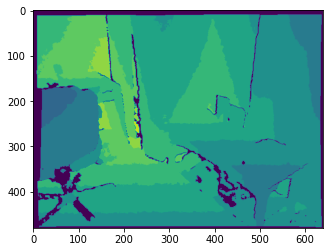

In [80]:
# read a depth image and display it
fpath = depth_dir / '1.png'
print(fpath)
img = cv2.imread(str(fpath), cv2.IMREAD_GRAYSCALE)
print(img.min(), img.max())
plt.imshow(img)

## create volume

In [97]:
volume = o3d.pipelines.integration.UniformTSDFVolume(length=4.0, resolution=512, sdf_trunc=0.04, 
                                        color_type=o3d.pipelines.integration.TSDFVolumeColorType.RGB8)

## add depth and rgb images

In [98]:
for pose_name in tqdm(os.listdir(pose_dir)[:10]):
    ndx = Path(pose_name).stem
    pose = np.genfromtxt(pose_dir / pose_name, delimiter=' ')
    
    color_big = o3d.io.read_image(str(color_dir / f'{ndx}.jpg'))
    color_np = cv2.resize(np.asarray(color_big), (640, 480))
    color = o3d.geometry.Image(color_np)
    
    depth = o3d.io.read_image(str(depth_dir / f'{ndx}.png'))
    
    rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(
        color, depth, depth_trunc=4.0, convert_rgb_to_intensity=False)
    volume.integrate(rgbd, intrinsic, np.linalg.inv(pose))

    

100%|██████████| 10/10 [00:01<00:00,  9.11it/s]


In [99]:
volume

UniformTSDFVolume with color.

## Extract a triangle mesh from the volume and visualize it.

In [92]:
mesh = volume.extract_triangle_mesh()
mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([mesh],
                                  front=[0.5297, -0.1873, -0.8272],
                                  lookat=[2.0712, 2.0312, 1.7251],
                                  up=[-0.0558, -0.9809, 0.1864],
                                  zoom=0.47)

AttributeError: module 'open3d' has no attribute 'visualization'

## get the voxel grid

In [100]:
voxelgrid = volume.extract_voxel_grid()
voxels = np.asarray(voxelgrid)
print(voxels.shape)

()
